<a href="https://colab.research.google.com/github/JamesMcGuigan/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/Week%201%20Exercise%20Question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !pip install tensorflow==2.0.0b1

In [44]:
import tensorflow as tf
import numpy as np
import scipy as sci
import sklearn
import matplotlib.pyplot as plt
from tensorflow import keras
print(tf.__version__)

# EXPECTED OUTPUT
# 2.0.0-beta1 (or later)

2.2.0-rc1


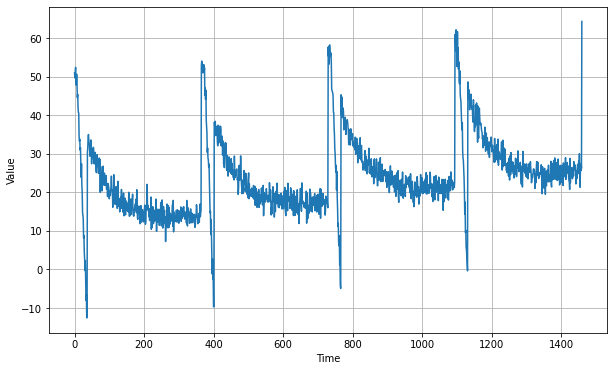

In [45]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 7 * np.pi),
                    1 / np.exp(5 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time      = np.arange(4 * 365 + 1, dtype="float32")
baseline  = 10
series    = trend(time, 0.1)  
baseline  = 10
amplitude = 40
slope     = 0.01
noise_level = 2

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

# EXPECTED OUTPUT
# Chart as in the screencast. First should have 5 distinctive 'peaks'

Now that we have the time series, let's split it so we can start forecasting

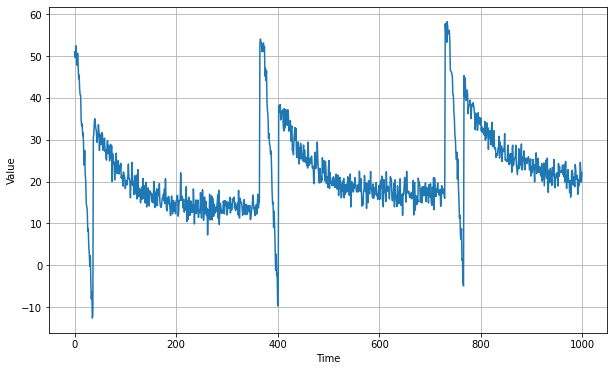

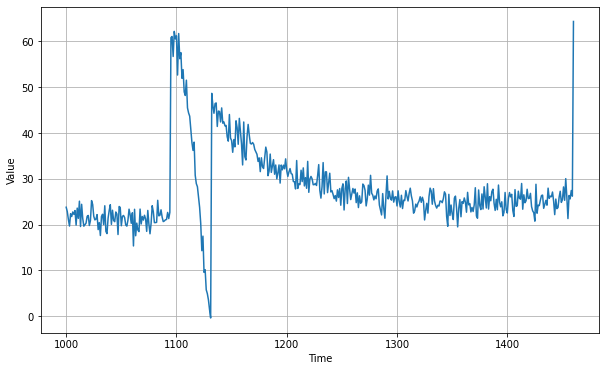

In [46]:
split_time = 1000
time_train = time[:split_time]
x_train    = series[:split_time]
time_valid = time[split_time:]
x_valid    = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

# EXPECTED OUTPUT
# Chart WITH 4 PEAKS between 50 and 65 and 3 troughs between -12 and 0
# Chart with 2 Peaks, first at slightly above 60, last at a little more than that, should also have a single trough at about 0

# Naive Forecast

In [0]:
naive_forecast = series[split_time-1:-1]

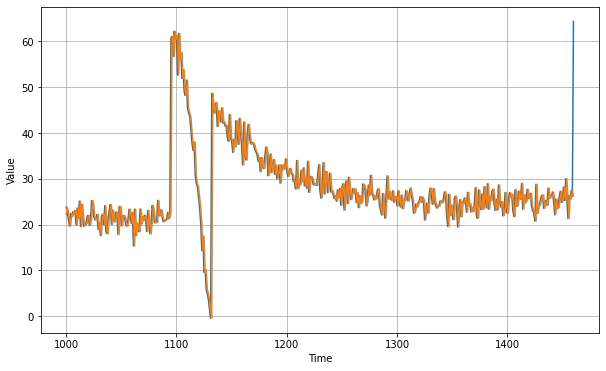

In [48]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

# Expected output: Chart similar to above, but with forecast overlay

Let's zoom in on the start of the validation period:

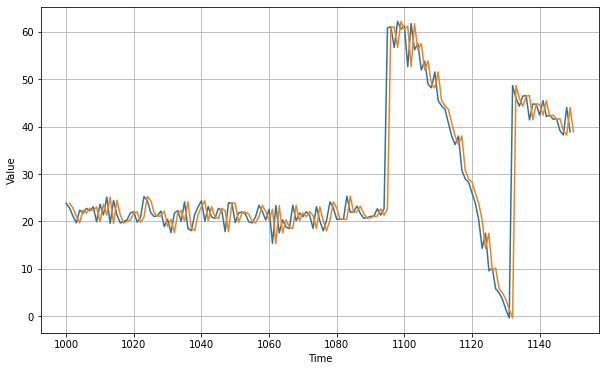

In [49]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid,        start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

# EXPECTED - Chart with X-Axis from 1100-1250 and Y Axes with series value and projections. Projections should be time stepped 1 unit 'after' series

Now let's compute the mean squared error and the mean absolute error between the forecasts and the predictions in the validation period:

In [50]:
print('numpy')
print( np.mean(np.square(x_valid - naive_forecast)) )
print( np.mean(np.abs(x_valid    - naive_forecast)) )

print()
print('sklearn.metrics')
import sklearn.metrics
print( sklearn.metrics.mean_squared_error(x_valid, naive_forecast))
print( sklearn.metrics.mean_absolute_error(    x_valid, naive_forecast))

print()
print('tf.keras.metrics')
print(tf.keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

# Expected Output
# 19.578304
# 2.6011968

numpy
20.158266
2.5868618

sklearn.metrics
20.158266
2.5868618

tf.keras.metrics
20.158268
2.5868616


That's our baseline, now let's try a moving average:

In [120]:
# https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
def moving_average_forecast_loop(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  return [ np.mean(series[n:n+window_size]) for n in range(0,len(series)-window_size)  ]


def moving_average_forecast_convolve(series, window_size):
  a = series
  n = window_size
  # return sci.convolve(a,np.ones(n,dtype='float'), 'same')/sci.convolve(np.ones(len(a)),np.ones(n), 'same')  
  return np.convolve(series,np.ones(n)/n, 'same')[n//2:len(a)-n//2]  

def moving_average_forecast(series, window_size):  
  # return moving_average_forecast_loop(series, window_size)
  return moving_average_forecast_convolve(series, window_size)

ERROR! Session/line number was not unique in database. History logging moved to new session 62


In [121]:
print( 'moving_average_forecast_loop([1,2,3,4,5], 2)',           moving_average_forecast_loop([1,2,3,4,5], 2) )
print( 'moving_average_forecast_loop([1,2,3,4,5,6,7,8,9,10],5)', moving_average_forecast_loop([1,2,3,4,5,6,7,8,9,10],5) )

print( 'moving_average_forecast_convolve([1,2,3,4,5], 2)',           moving_average_forecast_convolve([1,2,3,4,5], 2) )
print( 'moving_average_forecast_convolve([1,2,3,4,5,6,7,8,9,10],5)', moving_average_forecast_convolve([1,2,3,4,5,6,7,8,9,10],5) )

moving_average_forecast_loop([1,2,3,4,5], 2) [1.5, 2.5, 3.5]
moving_average_forecast_loop([1,2,3,4,5,6,7,8,9,10],5) [3.0, 4.0, 5.0, 6.0, 7.0]
moving_average_forecast_convolve([1,2,3,4,5], 2) [1.5 2.5 3.5]
moving_average_forecast_convolve([1,2,3,4,5,6,7,8,9,10],5) [3. 4. 5. 6. 7. 8.]


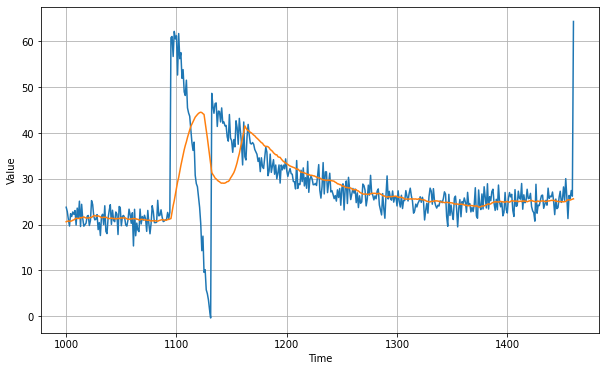

In [130]:
# moving_avg = moving_average_forecast(# YOUR CODE HERE)[# YOUR CODE HERE]
mva_window = 30
moving_avg = moving_average_forecast(series, mva_window)[split_time - mva_window:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)
    
# EXPECTED OUTPUT
# Chart with time series from 1100->1450+ on X
# Time series plotted
# Moving average plotted over it

In [131]:
print(sklearn.metrics.mean_squared_error(x_valid, moving_avg))
print(sklearn.metrics.mean_absolute_error(x_valid, moving_avg))
# EXPECTED OUTPUT
# 65.786224
# 4.3040023

66.60636640452735
4.080596202262829


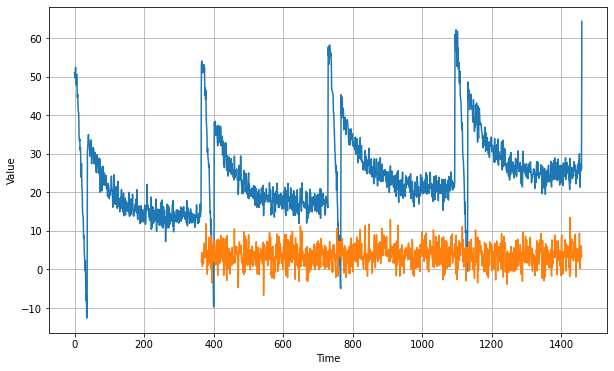

In [152]:
diff_series = (series[365:] - series[:-365] )
diff_time   = time[365:]

plt.figure(figsize=(10, 6))
plot_series(time, series)
plot_series(diff_time, diff_series)
plt.show()
    
# EXPECETED OUTPUT: Chart with diffs

Great, the trend and seasonality seem to be gone, so now we can use the moving average:

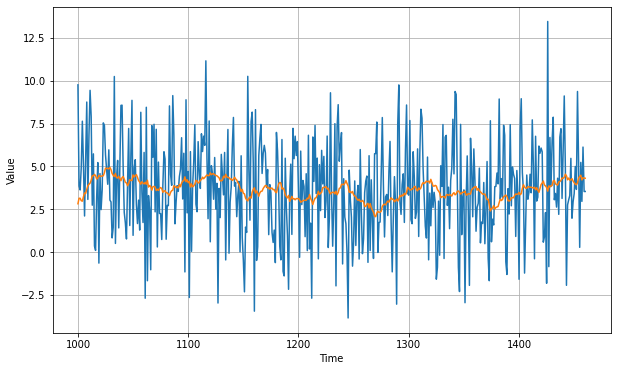

In [153]:
# diff_moving_avg = moving_average_forecast(diff_series, 30)
diff_moving_avg = moving_average_forecast(diff_series, 30)[split_time - 365 - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()
            
# Expected output. Diff chart from 1100->1450 +
# Overlaid with moving average

Now let's bring back the trend and seasonality by adding the past values from t – 365:

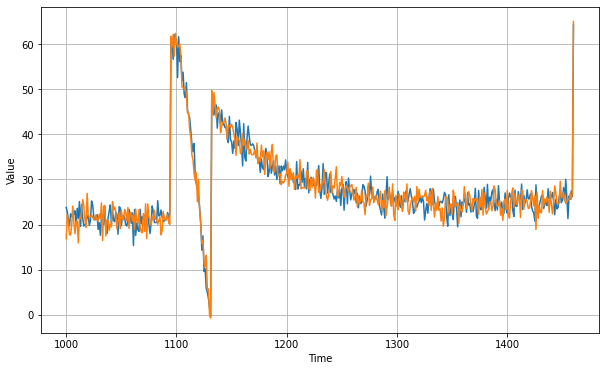

In [154]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()
# Expected output: Chart from 1100->1450+ on X. Same chart as earlier for time series, but projection overlaid looks close in value to it

In [155]:
print(sklearn.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past))
print(sklearn.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past))
# EXPECTED OUTPUT
# 8.498155
# 2.327179

8.60233264136924
2.3612965684521483


Better than naive forecast, good. However the forecasts look a bit too random, because we're just adding past values, which were noisy. Let's use a moving averaging on past values to remove some of the noise:

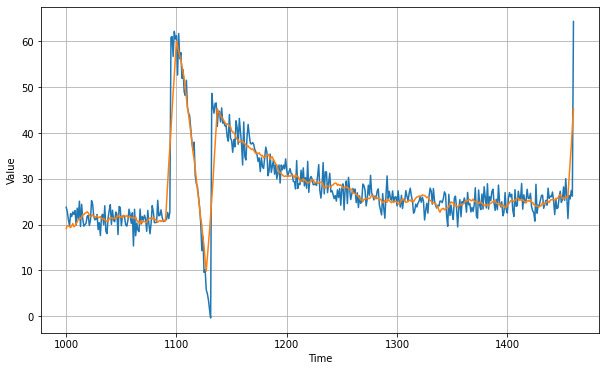

In [159]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 365-10//2:-365+10//2], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

# EXPECTED OUTPUT:
# Similar chart to above, but the overlaid projections are much smoother

In [160]:
print(sklearn.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past))
print(sklearn.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past))
# EXPECTED OUTPUT
# 12.527958
# 2.2034433

13.383858904084438
2.266975285997446
